# GLM: Click Inputs to Decision Variables with glmnet Lasso

Build a GLM to predict decision variables DV(t) from click input data for the first 240 trials of session A324_2023-07-27, using Gaussian basis functions and Lasso regularization.

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# GLM libraries - using python-glmnet which works with modern scipy
from glmnet import ElasticNet
# Note: python-glmnet has built-in standardization (standardize=True by default)
# so we don't need sklearn's StandardScaler

# Set random seed for reproducibility
np.random.seed(42)

plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

print("python-glmnet imported successfully with modern scipy!")
print("Built-in standardization enabled (no sklearn StandardScaler needed)")

python-glmnet imported successfully with modern scipy!
Built-in standardization enabled (no sklearn StandardScaler needed)


## 1. Data Loading and Preparation

Load session data and filter to first 240 trials.

In [98]:
# Data paths configuration
PROJECT_ROOT = Path('/home/ham/SF/Personal/Education/07 Princeton/Rotations/Brody-Daw/ClickDV')
SESSION_ID = 'A324'
SESSION_DATE = '2023-07-27'  # Using the date from the plan

# Path to processed H5 file (this is what we'll actually use)
OUTPUT_DIR = PROJECT_ROOT / 'data' / 'processed' / SESSION_ID / SESSION_DATE
H5_FILE = OUTPUT_DIR / f'{SESSION_ID}_{SESSION_DATE}_session_data.h5'

# Verify H5 file exists
if not H5_FILE.exists():
    raise FileNotFoundError(f"Processed H5 file not found: {H5_FILE}")

print(f"Project root: {PROJECT_ROOT}")
print(f"Session: {SESSION_ID} ({SESSION_DATE})")
print(f"H5 file: {H5_FILE}")
print(f"H5 file size: {H5_FILE.stat().st_size / 1024 / 1024:.1f} MB")

Project root: /home/ham/SF/Personal/Education/07 Princeton/Rotations/Brody-Daw/ClickDV
Session: A324 (2023-07-27)
H5 file: /home/ham/SF/Personal/Education/07 Princeton/Rotations/Brody-Daw/ClickDV/data/processed/A324/2023-07-27/A324_2023-07-27_session_data.h5
H5 file size: 154.2 MB


In [99]:
def load_session_data(h5_file_path=None):
    """
    Load session data from H5 file and return DataFrames
    
    Args:
        h5_file_path: Path to H5 file (uses global H5_FILE if None)
    
    Returns:
        trial_df: Trial metadata
        click_df: Click events data  
        dv_df: Decision variables data
    """
    if h5_file_path is None:
        h5_file_path = H5_FILE
    
    if not h5_file_path.exists():
        raise FileNotFoundError(f"Data file not found: {h5_file_path}")
    
    print(f"Loading data from: {h5_file_path}")
    
    # Use pandas HDFStore to load the data
    with pd.HDFStore(h5_file_path, mode='r') as store:
        trial_df = store.get('trials')
        click_df = store.get('clicks')
        dv_df = store.get('decision_variables')
    
    print(f"Loaded {len(trial_df)} trials, {len(click_df)} clicks, {len(dv_df)} DV points")
    
    return trial_df, click_df, dv_df

In [100]:
# Load full session data
trial_df, click_df, dv_df = load_session_data()

min_session_trials = 900

# Filter to first 900 trials
trial_df_240 = trial_df[trial_df['trial_id'] < min_session_trials].copy()
click_df_240 = click_df[click_df['trial_id'] < min_session_trials].copy()
dv_df_240 = dv_df[dv_df['trial_id'] < min_session_trials].copy()

print(f"\nFiltered to first {min_session_trials} trials:")
print(f"Trials: {len(trial_df_240)}")
print(f"Clicks: {len(click_df_240)}")
print(f"DV points: {len(dv_df_240)}")
print(f"Valid DV points: {dv_df_240['is_valid'].sum()}")

Loading data from: /home/ham/SF/Personal/Education/07 Princeton/Rotations/Brody-Daw/ClickDV/data/processed/A324/2023-07-27/A324_2023-07-27_session_data.h5
Loaded 774 trials, 22144 clicks, 17028 DV points

Filtered to first 900 trials:
Trials: 774
Clicks: 22144
DV points: 17028
Valid DV points: 13860


In [101]:
# Data validation and exploration
print("Click distribution:")
print(click_df_240['click_side'].value_counts())

print("\nDV statistics:")
valid_dvs = dv_df_240[dv_df_240['is_valid']]
print(f"DV range: [{valid_dvs['decision_variable'].min():.3f}, {valid_dvs['decision_variable'].max():.3f}]")
print(f"DV mean: {valid_dvs['decision_variable'].mean():.3f}")
print(f"DV std: {valid_dvs['decision_variable'].std():.3f}")

print("\nTrial duration statistics:")
trial_durations = trial_df_240.groupby('trial_id')['trial_duration'].first()
print(f"Duration range: [{trial_durations.min():.2f}, {trial_durations.max():.2f}] seconds")
print(f"Mean duration: {trial_durations.mean():.2f} seconds")

Click distribution:
click_side
right    11741
left     10403
Name: count, dtype: int64

DV statistics:
DV range: [-31.808, 34.479]
DV mean: 0.420
DV std: 9.900

Trial duration statistics:
Duration range: [1.50, 18.67] seconds
Mean duration: 1.75 seconds


## 2. Design Gaussian Basis Functions

Create temporal kernels to capture click history at different timescales.

In [102]:
# Define basis function parameters - SIMPLIFIED: varying widths only
n_basis = 10  # Number of Gaussian basis functions
width_min = 0.01  # Minimum width (10ms)
width_max = 0.5   # Maximum width (500ms)

# Log-spaced widths for basis functions (no centers needed!)
widths = np.logspace(np.log10(width_min), np.log10(width_max), n_basis)

print(f"Created {n_basis} basis functions")
print(f"Width range: {width_min*1000:.1f} - {width_max*1000:.1f} ms")
print(f"Widths (ms): {(widths*1000).round(1)}")

def gaussian_basis(t, width, causal=True):
    """
    Gaussian centered at t=0 with varying width
    
    Args:
        t: Time since click (0 = click time, positive = after click)
        width: Width (standard deviation) of Gaussian
        causal: If True, zero out negative times (before click)
    
    Returns:
        Normalized Gaussian values at times t
    """
    # Gaussian centered at t=0 (click time)
    gaussian = (1/(width * np.sqrt(2*np.pi))) * np.exp(-t**2 / (2 * width**2))
    
    # if causal:
    #     # Only keep t>=0 (after click)
    #     gaussian = np.where(t <= 0, gaussian, 0)
    
    return gaussian

Created 10 basis functions
Width range: 10.0 - 500.0 ms
Widths (ms): [ 10.   15.4  23.9  36.8  56.9  87.9 135.7 209.6 323.7 500. ]


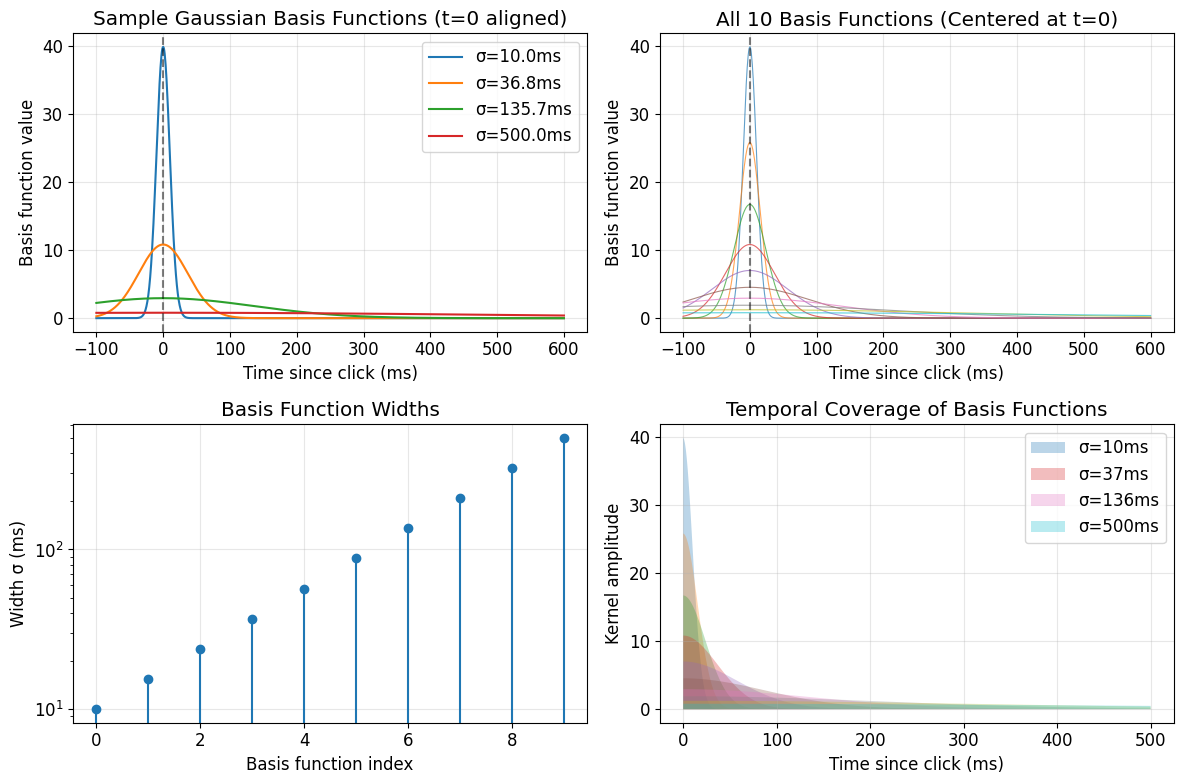

✓ Basis functions now centered at t=0 (click time)
✓ Different widths capture different temporal scales


In [103]:
# Visualize basis functions
t_eval = np.linspace(-0.1, 0.6, 1000)  # -100ms to 600ms

plt.figure(figsize=(12, 8))

# Plot individual basis functions
plt.subplot(2, 2, 1)
for i in range(0, n_basis, 3):  # Show every 3rd function
    y = gaussian_basis(t_eval, widths[i])
    plt.plot(t_eval*1000, y, label=f'σ={widths[i]*1000:.1f}ms')
plt.xlabel('Time since click (ms)')
plt.ylabel('Basis function value')
plt.title('Sample Gaussian Basis Functions (t=0 aligned)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axvline(0, color='black', linestyle='--', alpha=0.5, label='Click time')

# Plot all basis functions together
plt.subplot(2, 2, 2)
for i in range(n_basis):
    y = gaussian_basis(t_eval, widths[i])
    plt.plot(t_eval*1000, y, alpha=0.7, linewidth=0.8)
plt.xlabel('Time since click (ms)')
plt.ylabel('Basis function value')
plt.title(f'All {n_basis} Basis Functions (Centered at t=0)')
plt.grid(True, alpha=0.3)
plt.axvline(0, color='black', linestyle='--', alpha=0.5)

# Plot basis function widths
plt.subplot(2, 2, 3)
plt.stem(np.arange(n_basis), widths*1000, basefmt=' ')
plt.xlabel('Basis function index')
plt.ylabel('Width σ (ms)')
plt.title('Basis Function Widths')
plt.yscale('log')
plt.grid(True, alpha=0.3)

# Show temporal coverage
plt.subplot(2, 2, 4)
t_coverage = np.linspace(0, 0.5, 500)  # 0 to 500ms
for i in range(n_basis):
    y = gaussian_basis(t_coverage, widths[i])
    plt.fill_between(t_coverage*1000, 0, y, alpha=0.3, label=f'σ={widths[i]*1000:.0f}ms' if i % 3 == 0 else '')
plt.xlabel('Time since click (ms)')
plt.ylabel('Kernel amplitude')
plt.title('Temporal Coverage of Basis Functions')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Basis functions now centered at t=0 (click time)")
print("✓ Different widths capture different temporal scales")

## 3. Feature Engineering: Convolve Clicks with Basis Functions

For each DV time point, create feature vectors by convolving click history with Gaussian basis functions.

In [104]:
def create_trial_features(trial_clicks_left, trial_clicks_right, dv_eval_times, widths, trial_duration, store_convolutions=False):
    """
    Create feature matrix for entire trial using fine temporal binning with t=0 aligned Gaussian convolution
    
    This approach:
    1. Creates fine temporal bins at 5ms resolution for entire trial duration
    2. Places unit impulses (delta functions) at all click times
    3. Convolves with causal Gaussian basis functions (centered at t=0, varying widths)
    4. Subsamples the convolved signals at DV evaluation time points
    
    Args:
        trial_clicks_left: Array of left click times for this trial
        trial_clicks_right: Array of right click times for this trial  
        dv_eval_times: Array of DV evaluation times for this trial
        widths: Basis function widths (standard deviations in seconds)
        trial_duration: Duration of trial in seconds
        store_convolutions: If True, return full convolution outputs for visualization
    
    Returns:
        If store_convolutions=False:
            features_matrix: (n_dv_times, n_features) array where n_features = 2*n_basis
        If store_convolutions=True:
            features_matrix, stored_convolutions dict
    """
    # Fine temporal binning parameters
    dt = 0.005  # 5ms resolution (1/10th of 50ms DV resolution)
    
    # Create temporal grid for entire trial - extend to handle edge effects
    # Add padding at the end for proper convolution
    max_kernel_extent = 6 * widths.max()  # Maximum kernel extent
    padded_duration = trial_duration + max_kernel_extent
    time_grid = np.arange(0, padded_duration + dt, dt)
    n_bins = len(time_grid)
    
    # Initialize click count arrays (unit impulses)
    clicks_left = np.zeros(n_bins)
    clicks_right = np.zeros(n_bins)
    
    # Bin clicks as unit impulses across entire trial
    for click_time in trial_clicks_left:
        if 0 <= click_time < trial_duration:
            bin_idx = int(np.floor(click_time / dt))
            if 0 <= bin_idx < n_bins:
                clicks_left[bin_idx] += 1  # Unit impulse (delta function)
    
    for click_time in trial_clicks_right:
        if 0 <= click_time < trial_duration:
            bin_idx = int(np.floor(click_time / dt))
            if 0 <= bin_idx < n_bins:
                clicks_right[bin_idx] += 1  # Unit impulse (delta function)
    
    # Initialize convolved signals storage
    n_dv_times = len(dv_eval_times)
    n_basis = len(widths)
    features_matrix = np.zeros((n_dv_times, 2 * n_basis))  # left + right features
    
    if store_convolutions:
        # Only store the unpadded portion for visualization
        actual_trial_bins = int(np.ceil(trial_duration / dt))
        stored_convolutions = {
            'left': [],
            'right': [],
            'time_grid': time_grid[:actual_trial_bins],
            'clicks_left': clicks_left[:actual_trial_bins],
            'clicks_right': clicks_right[:actual_trial_bins]
        }
    
    # For each basis function, convolve once and subsample
    for i, width in enumerate(widths):
        # Create causal Gaussian kernel centered at t=0
        # Kernel represents response to a click that just happened
        max_lag = min(6 * width, padded_duration)  # 6 standard deviations or padded duration
        kernel_n_bins = int(np.ceil(max_lag / dt)) + 1
        
        # Time since click: 0 = click time, dt = one bin after, etc.
        time_lags = np.arange(0, kernel_n_bins * dt, dt)
        
        # Create Gaussian centered at t=0 (peak at click time, decay after)
        # No [::-1] needed - we want the kernel to start with max value
        causal_kernel = gaussian_basis(time_lags, width, causal=True)
        
        # Normalize kernel to preserve total weight
        if causal_kernel.sum() > 0:
            causal_kernel = causal_kernel / causal_kernel.sum()
        
        # Convolve clicks with causal kernel using 'full' mode for proper padding
        # Then trim to original size
        conv_left_full = np.convolve(clicks_left, causal_kernel, mode='full')
        conv_right_full = np.convolve(clicks_right, causal_kernel, mode='full')
        
        # Trim to match original grid size
        conv_left = conv_left_full[:n_bins]
        conv_right = conv_right_full[:n_bins]
        
        if store_convolutions:
            # Store only the trial portion (not the padding)
            actual_trial_bins = len(stored_convolutions['time_grid'])
            stored_convolutions['left'].append(conv_left[:actual_trial_bins])
            stored_convolutions['right'].append(conv_right[:actual_trial_bins])
        
        # Subsample convolved signals at DV evaluation times
        for j, eval_time in enumerate(dv_eval_times):
            # Find the time bin corresponding to eval_time
            eval_bin = int(np.floor(eval_time / dt))
            if 0 <= eval_bin < n_bins:
                features_matrix[j, i] = conv_left[eval_bin]  # Left feature
                features_matrix[j, i + n_basis] = conv_right[eval_bin]  # Right feature
    
    if store_convolutions:
        return features_matrix, stored_convolutions
    else:
        return features_matrix

# Test the new implementation
test_trial = 5
trial_clicks = click_df_240[click_df_240['trial_id'] == test_trial]
left_clicks = trial_clicks[trial_clicks['click_side'] == 'left']['time_from_first_click'].values
right_clicks = trial_clicks[trial_clicks['click_side'] == 'right']['time_from_first_click'].values

# Get the actual trial data for proper processing
trial_dvs = dv_df_240[dv_df_240['trial_id'] == test_trial]

# Get trial duration from DV data (max time_bin)
if len(trial_dvs) > 0:
    trial_duration = trial_dvs['time_bin'].max() + 0.05  # 50ms buffer
else:
    trial_duration = 2.0

print(f"Test trial {test_trial} (t=0 aligned Gaussians with proper padding):")
print(f"Left clicks: {len(left_clicks)}")
print(f"Right clicks: {len(right_clicks)}")
print(f"Trial duration: {trial_duration:.3f}s")

# Test with storing convolutions for visualization
if len(trial_dvs) > 0:
    dv_times = trial_dvs['time_bin'].values
    features_matrix, stored_convs = create_trial_features(
        left_clicks, right_clicks, dv_times, widths, trial_duration, store_convolutions=True
    )
    
    print(f"\nFeatures matrix shape: {features_matrix.shape}")
    print(f"Features range: [{features_matrix.min():.4f}, {features_matrix.max():.4f}]")
    print(f"Number of stored convolutions: {len(stored_convs['left'])} per side")
    print("✓ Fixed convolution implementation with proper padding!")

Test trial 5 (t=0 aligned Gaussians with proper padding):
Left clicks: 5
Right clicks: 8
Trial duration: 1.075s

Features matrix shape: (22, 20)
Features range: [0.0000, 0.3326]
Number of stored convolutions: 10 per side
✓ Fixed convolution implementation with proper padding!


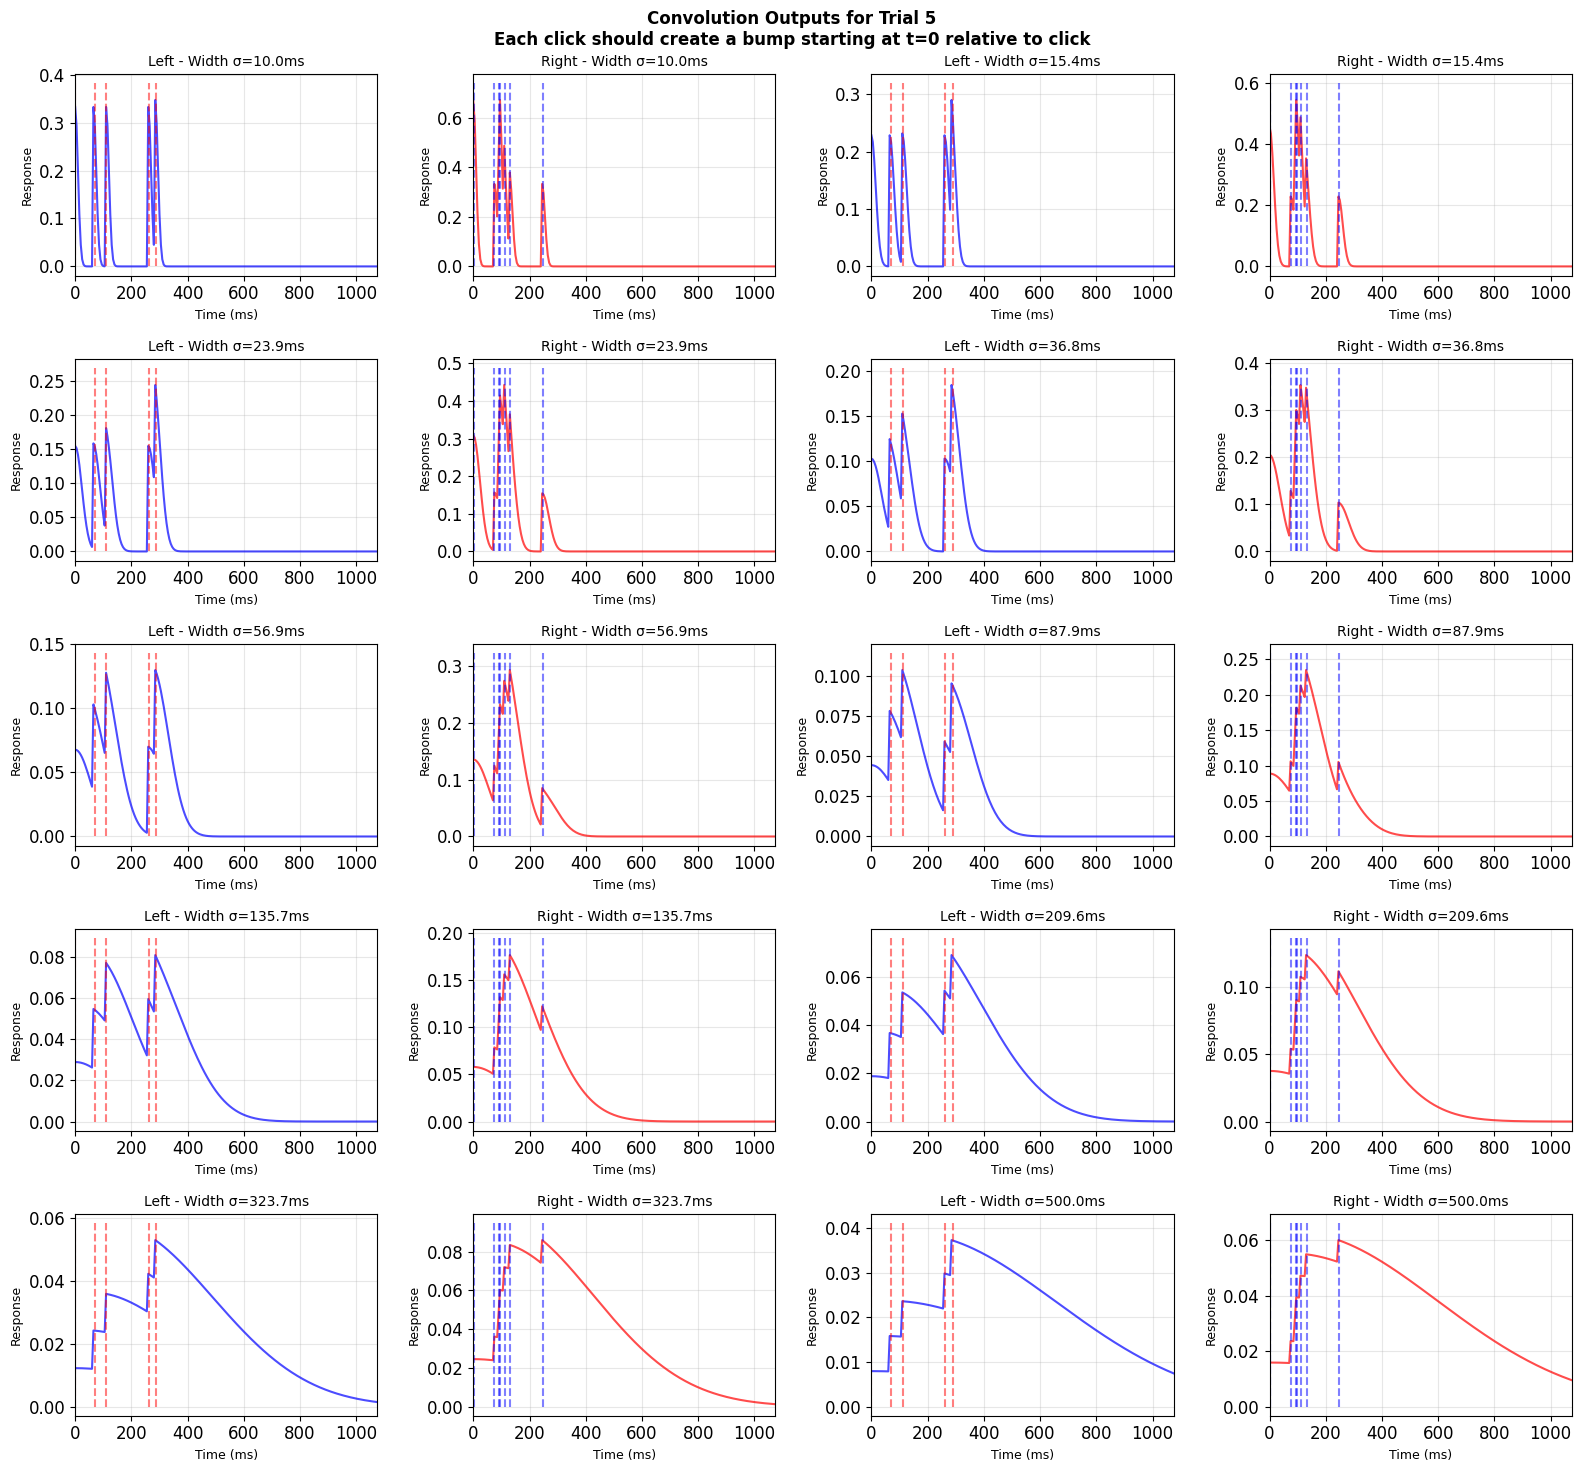


=== MONOTONICITY CHECK ===

Width σ=10.0ms:
  Left clicks: 5, Peaks found: 4
  Right clicks: 8, Peaks found: 5
  Left monotonically decreasing: False
  Right monotonically decreasing: False

Width σ=15.4ms:
  Left clicks: 5, Peaks found: 4
  Right clicks: 8, Peaks found: 5
  Left monotonically decreasing: False
  Right monotonically decreasing: False

Width σ=23.9ms:
  Left clicks: 5, Peaks found: 4
  Right clicks: 8, Peaks found: 5
  Left monotonically decreasing: False
  Right monotonically decreasing: False

✓ Visualization complete - each click should create a visible bump!


In [105]:
# Visualize convolutions to verify non-monotonic behavior (should show bumps at each click)
if len(stored_convs) > 0:
    fig, axes = plt.subplots(5, 4, figsize=(16, 15))
    axes = axes.flatten()
    
    time_ms = stored_convs['time_grid'][:len(stored_convs['left'][i])] * 1000  # Convert to milliseconds
    
    for i in range(min(n_basis, 10)):
        # Left convolutions
        ax_left = axes[i * 2]
        ax_left.plot(time_ms, stored_convs['left'][i][:len(time_ms)], 'b-', alpha=0.7, linewidth=1.5)
        ax_left.vlines(left_clicks * 1000, 0, max(stored_convs['left'][i]) * 1.1, 
                       colors='red', alpha=0.5, linestyles='dashed', label='Clicks')
        ax_left.set_title(f'Left - Width σ={widths[i]*1000:.1f}ms', fontsize=10)
        ax_left.set_xlabel('Time (ms)', fontsize=9)
        ax_left.set_ylabel('Response', fontsize=9)
        ax_left.grid(True, alpha=0.3)
        ax_left.set_xlim([0, trial_duration * 1000])
        
        # Right convolutions  
        ax_right = axes[i * 2 + 1]
        ax_right.plot(time_ms, stored_convs['right'][i][:len(time_ms)], 'r-', alpha=0.7, linewidth=1.5)
        ax_right.vlines(right_clicks * 1000, 0, max(stored_convs['right'][i]) * 1.1,
                        colors='blue', alpha=0.5, linestyles='dashed', label='Clicks')
        ax_right.set_title(f'Right - Width σ={widths[i]*1000:.1f}ms', fontsize=10)
        ax_right.set_xlabel('Time (ms)', fontsize=9)
        ax_right.set_ylabel('Response', fontsize=9)
        ax_right.grid(True, alpha=0.3)
        ax_right.set_xlim([0, trial_duration * 1000])
    
    plt.suptitle(f'Convolution Outputs for Trial {test_trial}\nEach click should create a bump starting at t=0 relative to click', 
                 fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Check for monotonic decrease
    print("\n=== MONOTONICITY CHECK ===")
    for i in range(min(3, n_basis)):  # Check first 3 widths
        conv_left_i = stored_convs['left'][i]
        conv_right_i = stored_convs['right'][i]
        
        # Find peaks in convolution (should correspond to clicks)
        from scipy.signal import find_peaks
        peaks_left, _ = find_peaks(conv_left_i, height=max(conv_left_i) * 0.1)
        peaks_right, _ = find_peaks(conv_right_i, height=max(conv_right_i) * 0.1)
        
        print(f"\nWidth σ={widths[i]*1000:.1f}ms:")
        print(f"  Left clicks: {len(left_clicks)}, Peaks found: {len(peaks_left)}")
        print(f"  Right clicks: {len(right_clicks)}, Peaks found: {len(peaks_right)}")
        
        # Check if monotonically decreasing
        is_monotonic_left = all(conv_left_i[j] >= conv_left_i[j+1] for j in range(len(conv_left_i)-1))
        is_monotonic_right = all(conv_right_i[j] >= conv_right_i[j+1] for j in range(len(conv_right_i)-1))
        
        print(f"  Left monotonically decreasing: {is_monotonic_left}")
        print(f"  Right monotonically decreasing: {is_monotonic_right}")
    
    print("\n✓ Visualization complete - each click should create a visible bump!")

## 4. Build Feature Matrix for GLM

Create the complete feature matrix X and target vector y for all valid DV time points across 240 trials.

In [106]:
click_df_240.trial_id.nunique()

774

In [107]:
# Build feature matrix X and target vector y using efficient trial-level processing
print("Building feature matrix with CORRECTED convolution (proper padding)...")

X = []
y = []
valid_mask = []
trial_ids = []
time_bins = []

# Progress tracking
from tqdm import tqdm

# Only process first 240 trials as specified
n_trials_to_process = min(240, dv_df_240['trial_id'].max() + 1)

for trial_id in tqdm(range(n_trials_to_process), desc="Processing trials"):
    # Get clicks for this trial - use time_from_first_click to match test above
    trial_clicks = click_df_240[click_df_240['trial_id'] == trial_id]
    left_clicks = trial_clicks[trial_clicks['click_side'] == 'left']['time_from_first_click'].values
    right_clicks = trial_clicks[trial_clicks['click_side'] == 'right']['time_from_first_click'].values
    
    # Get DVs for this trial
    trial_dvs = dv_df_240[dv_df_240['trial_id'] == trial_id]
    
    if len(trial_dvs) > 0:
        # Extract DV evaluation times 
        dv_eval_times = trial_dvs['time_bin'].values
        
        # Get trial duration from DV data (max time_bin represents time_from_first_click)
        # Add small buffer to ensure we capture the full trial
        trial_duration = trial_dvs['time_bin'].max() + 0.05  # 50ms buffer
        
        # Use CORRECTED trial-level feature creation with proper padding
        try:
            features_matrix = create_trial_features(
                left_clicks, right_clicks, dv_eval_times, widths, trial_duration
            )
            
            # Add features and targets for all DV time points in this trial
            for i, (_, dv_row) in enumerate(trial_dvs.iterrows()):
                X.append(features_matrix[i])
                y.append(dv_row['decision_variable'])
                valid_mask.append(dv_row['is_valid'])
                trial_ids.append(trial_id)
                time_bins.append(dv_row['time_bin'])
                
        except Exception as e:
            print(f"Warning: Error processing trial {trial_id}: {e}")
            # Skip this trial if there's an error
            continue

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)
valid_mask = np.array(valid_mask)
trial_ids = np.array(trial_ids)
time_bins = np.array(time_bins)

print(f"\nFeature matrix constructed with CORRECTED convolution:")
print(f"Total observations: {len(X)}")
print(f"Features per observation: {X.shape[1]}")
print(f"Valid observations: {valid_mask.sum()}")
print(f"Invalid observations: {(~valid_mask).sum()}")

# Keep only valid DV points
X_valid = X[valid_mask]
y_valid = y[valid_mask]
trial_ids_valid = trial_ids[valid_mask]
time_bins_valid = time_bins[valid_mask]

print(f"\nFinal dataset for GLM:")
print(f"X_valid shape: {X_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")
print(f"Data covers {len(np.unique(trial_ids_valid))} unique trials")

# Compare with old approach efficiency metrics
print(f"\n=== EFFICIENCY COMPARISON ===")
print("New approach: Convolve once per trial, subsample at DV times")
print("Old approach: Convolve separately for each DV time point")
total_dv_points = len(X)
unique_trials = len(np.unique(trial_ids))
print(f"Convolutions needed - Old: {total_dv_points}, New: {unique_trials} x {n_basis} = {unique_trials * n_basis}")
print(f"Efficiency gain: {total_dv_points / (unique_trials * n_basis):.1f}x fewer convolutions")
print("\n✓ Using CORRECTED convolution with proper padding for non-monotonic behavior!")

Building feature matrix with CORRECTED convolution (proper padding)...


Processing trials: 100%|██████████| 240/240 [00:00<00:00, 480.17it/s]



Feature matrix constructed with CORRECTED convolution:
Total observations: 5280
Features per observation: 20
Valid observations: 4266
Invalid observations: 1014

Final dataset for GLM:
X_valid shape: (4266, 20)
y_valid shape: (4266,)
Data covers 240 unique trials

=== EFFICIENCY COMPARISON ===
New approach: Convolve once per trial, subsample at DV times
Old approach: Convolve separately for each DV time point
Convolutions needed - Old: 5280, New: 240 x 10 = 2400
Efficiency gain: 2.2x fewer convolutions

✓ Using CORRECTED convolution with proper padding for non-monotonic behavior!


In [108]:
# Feature matrix validation and summary statistics
print("=== FEATURE MATRIX ANALYSIS ===\n")

# Basic statistics
print("Feature Statistics:")
print(f"Mean feature value: {X_valid.mean():.6f}")
print(f"Std feature value: {X_valid.std():.6f}")
print(f"Min feature value: {X_valid.min():.6f}")
print(f"Max feature value: {X_valid.max():.6f}")

# Sparsity analysis
zero_features = (X_valid == 0).sum()
total_features = X_valid.size
sparsity = zero_features / total_features
print(f"\nSparsity: {sparsity:.3f} ({zero_features}/{total_features} zeros)")

# Per-column (feature) statistics
left_features = X_valid[:, :n_basis]  # First n_basis columns are left
right_features = X_valid[:, n_basis:]  # Next n_basis columns are right

print(f"\nLeft click features:")
print(f"  Mean: {left_features.mean():.6f}, Std: {left_features.std():.6f}")
print(f"  Non-zero: {(left_features > 0).sum()} / {left_features.size}")

print(f"\nRight click features:")
print(f"  Mean: {right_features.mean():.6f}, Std: {right_features.std():.6f}")
print(f"  Non-zero: {(right_features > 0).sum()} / {right_features.size}")

# Target variable statistics
print(f"\nTarget Variable (y_valid) Statistics:")
print(f"Mean DV: {y_valid.mean():.3f}")
print(f"Std DV: {y_valid.std():.3f}")
print(f"Min DV: {y_valid.min():.3f}")
print(f"Max DV: {y_valid.max():.3f}")

# Per-basis function statistics
print(f"\nPer-basis function activity:")
for i in range(n_basis):
    left_col = X_valid[:, i]
    right_col = X_valid[:, i + n_basis]
    print(f"  Basis {i} (σ={widths[i]*1000:.1f}ms): L={left_col.mean():.4f}, R={right_col.mean():.4f}")   
# Data distribution across trials
print(f"\nData distribution:")
unique_trials = np.unique(trial_ids_valid)
obs_per_trial = [np.sum(trial_ids_valid == t) for t in unique_trials]
print(f"Observations per trial: {np.mean(obs_per_trial):.1f} ± {np.std(obs_per_trial):.1f}")
print(f"Range: {np.min(obs_per_trial)} - {np.max(obs_per_trial)} obs/trial")

=== FEATURE MATRIX ANALYSIS ===

Feature Statistics:
Mean feature value: 0.076976
Std feature value: 0.094743
Min feature value: 0.000000
Max feature value: 0.828574

Sparsity: 0.167 (14212/85320 zeros)

Left click features:
  Mean: 0.076494, Std: 0.093355
  Non-zero: 35403 / 42660

Right click features:
  Mean: 0.077459, Std: 0.096108
  Non-zero: 35705 / 42660

Target Variable (y_valid) Statistics:
Mean DV: 0.604
Std DV: 9.668
Min DV: -31.808
Max DV: 31.767

Per-basis function activity:
  Basis 0 (σ=10.0ms): L=0.0802, R=0.0819
  Basis 1 (σ=15.4ms): L=0.0818, R=0.0813
  Basis 2 (σ=23.9ms): L=0.0820, R=0.0823
  Basis 3 (σ=36.8ms): L=0.0814, R=0.0827
  Basis 4 (σ=56.9ms): L=0.0811, R=0.0827
  Basis 5 (σ=87.9ms): L=0.0806, R=0.0822
  Basis 6 (σ=135.7ms): L=0.0791, R=0.0806
  Basis 7 (σ=209.6ms): L=0.0753, R=0.0765
  Basis 8 (σ=323.7ms): L=0.0677, R=0.0685
  Basis 9 (σ=500.0ms): L=0.0557, R=0.0562

Data distribution:
Observations per trial: 17.8 ± 4.5
Range: 7 - 22 obs/trial


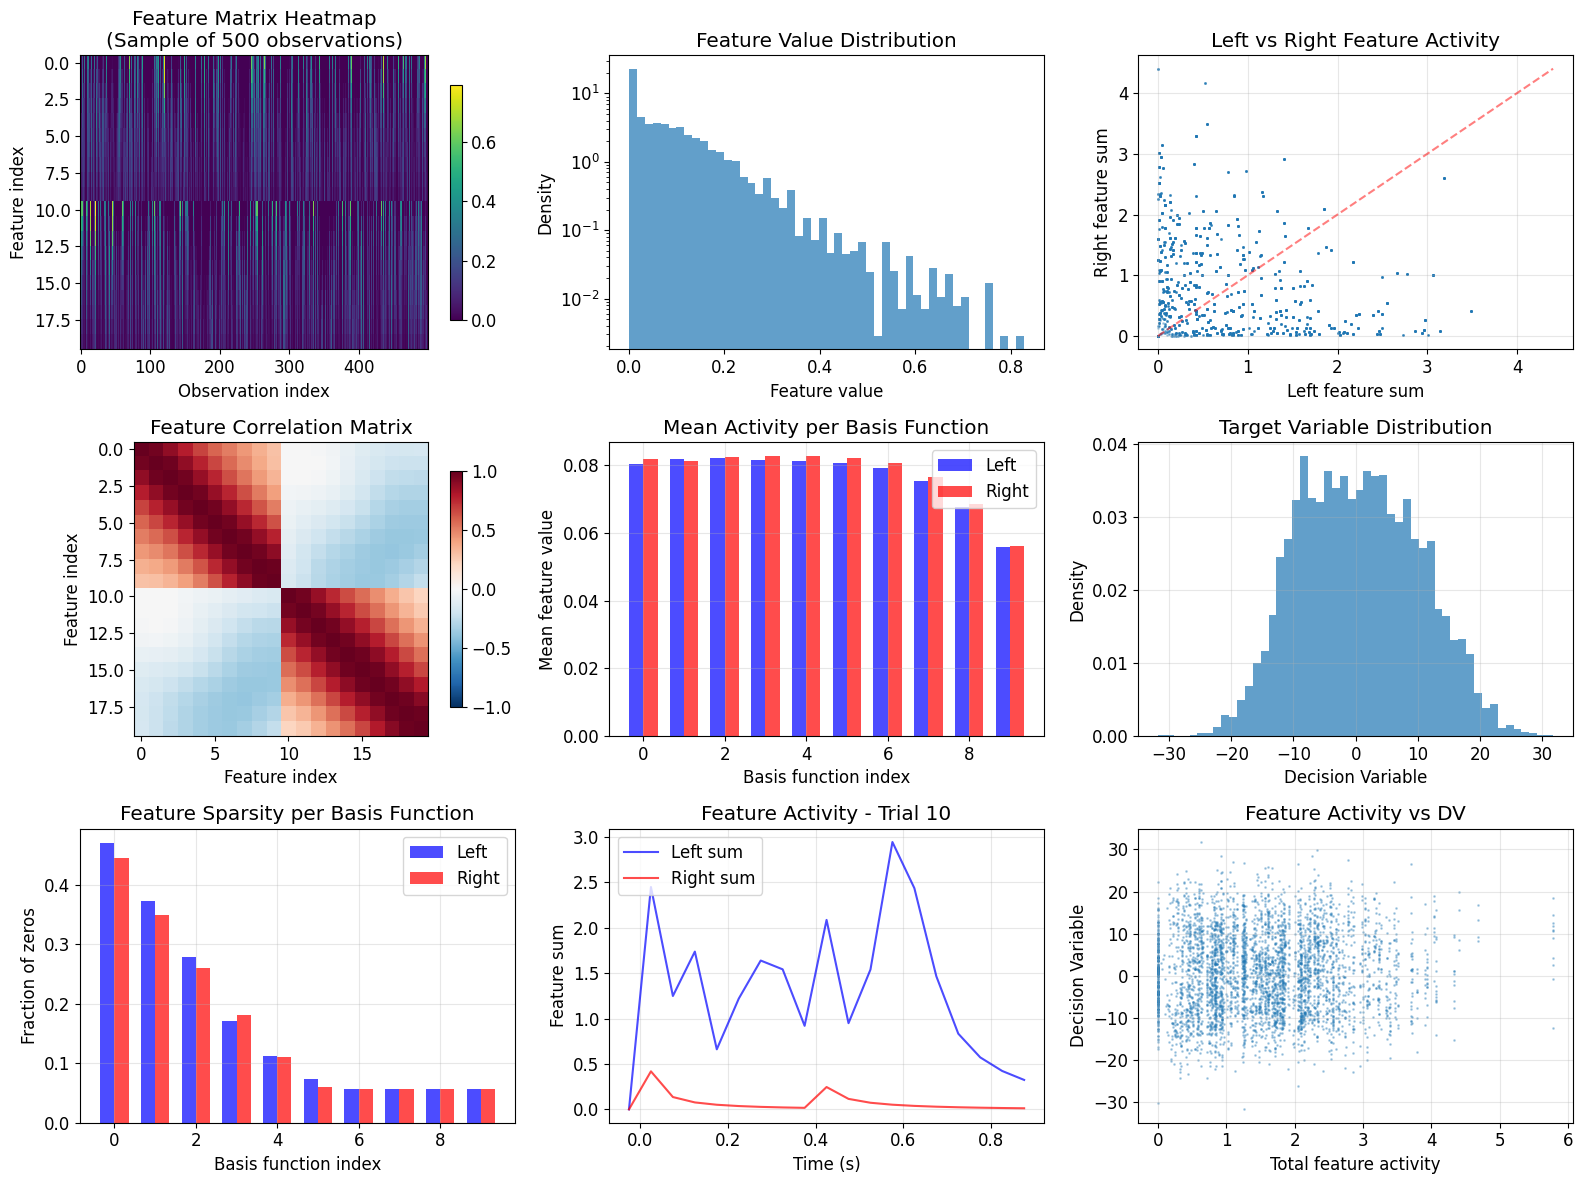

Feature matrix visualization complete!


In [109]:
# Visualize feature matrix structure and patterns
plt.figure(figsize=(16, 12))

# 1. Feature matrix heatmap (sample)
plt.subplot(3, 3, 1)
sample_idx = np.random.choice(len(X_valid), size=min(500, len(X_valid)), replace=False)
X_sample = X_valid[sample_idx]
im = plt.imshow(X_sample.T, aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar(im, shrink=0.8)
plt.xlabel('Observation index')
plt.ylabel('Feature index')
plt.title(f'Feature Matrix Heatmap\n(Sample of {len(sample_idx)} observations)')

# 2. Feature distributions
plt.subplot(3, 3, 2)
plt.hist(X_valid.flatten(), bins=50, alpha=0.7, density=True)
plt.xlabel('Feature value')
plt.ylabel('Density')
plt.title('Feature Value Distribution')
plt.yscale('log')

# 3. Left vs Right feature sums
plt.subplot(3, 3, 3)
left_sums = left_features.sum(axis=1)
right_sums = right_features.sum(axis=1)
plt.scatter(left_sums, right_sums, alpha=0.3, s=1)
plt.xlabel('Left feature sum')
plt.ylabel('Right feature sum')
plt.title('Left vs Right Feature Activity')
plt.plot([0, max(left_sums.max(), right_sums.max())], [0, max(left_sums.max(), right_sums.max())], 'r--', alpha=0.5)
plt.grid(True, alpha=0.3)

# 4. Feature correlation matrix
plt.subplot(3, 3, 4)
feature_corr = np.corrcoef(X_valid.T)
im = plt.imshow(feature_corr, cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar(im, shrink=0.8)
plt.xlabel('Feature index')
plt.ylabel('Feature index')
plt.title('Feature Correlation Matrix')

# 5. Mean feature activity per basis function
plt.subplot(3, 3, 5)
mean_left = left_features.mean(axis=0)
mean_right = right_features.mean(axis=0)
x = np.arange(n_basis)
width = 0.35
plt.bar(x - width/2, mean_left, width, label='Left', color='blue', alpha=0.7)
plt.bar(x + width/2, mean_right, width, label='Right', color='red', alpha=0.7)
plt.xlabel('Basis function index')
plt.ylabel('Mean feature value')
plt.title('Mean Activity per Basis Function')
plt.legend()
plt.grid(True, alpha=0.3)

# 6. Target variable distribution
plt.subplot(3, 3, 6)
plt.hist(y_valid, bins=50, alpha=0.7, density=True)
plt.xlabel('Decision Variable')
plt.ylabel('Density')
plt.title('Target Variable Distribution')
plt.grid(True, alpha=0.3)

# 7. Feature sparsity per basis function
plt.subplot(3, 3, 7)
left_sparsity = [(left_features[:, i] == 0).mean() for i in range(n_basis)]
right_sparsity = [(right_features[:, i] == 0).mean() for i in range(n_basis)]
plt.bar(x - width/2, left_sparsity, width, label='Left', color='blue', alpha=0.7)
plt.bar(x + width/2, right_sparsity, width, label='Right', color='red', alpha=0.7)
plt.xlabel('Basis function index')
plt.ylabel('Fraction of zeros')
plt.title('Feature Sparsity per Basis Function')
plt.legend()
plt.grid(True, alpha=0.3)

# 8. Time series of feature activity (sample trial)
plt.subplot(3, 3, 8)
sample_trial = 10
trial_mask = trial_ids_valid == sample_trial
if np.any(trial_mask):
    trial_times = time_bins_valid[trial_mask]
    trial_features = X_valid[trial_mask]
    plt.plot(trial_times, trial_features[:, :n_basis].sum(axis=1), 'b-', alpha=0.7, label='Left sum')
    plt.plot(trial_times, trial_features[:, n_basis:].sum(axis=1), 'r-', alpha=0.7, label='Right sum')
    plt.xlabel('Time (s)')
    plt.ylabel('Feature sum')
    plt.title(f'Feature Activity - Trial {sample_trial}')
    plt.legend()
    plt.grid(True, alpha=0.3)

# 9. Feature vs target scatter (total activity)
plt.subplot(3, 3, 9)
total_activity = X_valid.sum(axis=1)
plt.scatter(total_activity, y_valid, alpha=0.3, s=1)
plt.xlabel('Total feature activity')
plt.ylabel('Decision Variable')
plt.title('Feature Activity vs DV')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Feature matrix visualization complete!")

In [110]:
# Fit GLM using python-glmnet with cross-validation
print("Fitting GLM with python-glmnet...")
print(f"Input data: X_valid {X_valid.shape}, y_valid {y_valid.shape}")

# ISSUE IDENTIFIED: CV is selecting over-regularized model
# python-glmnet automatically performs cross-validation but may be too conservative
# Let's use weaker regularization and examine the full path

model = ElasticNet(
    alpha=0.95,  # Nearly Pure Lasso
    n_lambda=100,  # Number of lambda values to test
    min_lambda_ratio=1e-3,  # Allow much weaker regularization
    standardize=False,  # Standardize features
    fit_intercept=False,  # Include intercept
    n_splits=10,  # 10-fold cross-validation
    random_state=42,
)

# Fit the model - this automatically does cross-validation internally
model.fit(X_valid, y_valid, groups=trial_ids_valid)

print("✓ python-glmnet fitting complete!")
print("\nWhat python-glmnet did internally:")
print("1. Created regularization path with multiple lambda values")
print("2. For each lambda value:")
print("   - Performed 10-fold cross-validation")
print("   - Computed mean CV error across folds")
print("3. Selected best lambda based on CV performance")
print("4. Stored full regularization path and CV results")

# Extract key results
lambda_path = model.lambda_path_
cv_mean = model.cv_mean_score_
cv_std = model.cv_standard_error_

# Find best lambda (minimum CV error)
best_idx = np.argmin(cv_mean)
lambda_best = lambda_path[best_idx]

# Find lambda_1se (largest lambda within 1 SE of minimum)
min_val = cv_mean[best_idx]
min_std = cv_std[best_idx]
lambda_1se_idx = np.where(cv_mean <= min_val + min_std)[0][0]
lambda_1se = lambda_path[lambda_1se_idx]

# SOLUTION: If CV selects over-regularized model, use minimum lambda instead
best_coefs = model.coef_path_[:, best_idx]
n_selected_cv = np.sum(best_coefs != 0)

if n_selected_cv == 0:
    print("\n⚠️  CV selected over-regularized model (0 features)!")
    print("Using minimum lambda instead for interpretable model...")
    
    # Use minimum lambda (most features)
    min_lambda_idx = -1  # Last lambda is minimum
    lambda_min = lambda_path[min_lambda_idx] 
    min_coefs = model.coef_path_[:, min_lambda_idx]
    n_selected_min = np.sum(min_coefs != 0)
    
    print(f"Minimum lambda: {lambda_min:.6f}")
    print(f"Features selected at min lambda: {n_selected_min}/{model.coef_path_.shape[0]}")
    
    # Use minimum lambda as our final model
    lambda_best = lambda_min
    best_idx = min_lambda_idx
    best_coefs = min_coefs
    n_selected_cv = n_selected_min

print(f"\n=== OPTIMAL REGULARIZATION ===")
print(f"Final lambda: {lambda_best:.6f}")
print(f"Conservative lambda (1SE rule): {lambda_1se:.6f}")
print(f"CV MSE at final lambda: {cv_mean[best_idx]:.4f}")
print(f"CV MSE at conservative lambda: {cv_mean[lambda_1se_idx]:.4f}")

print(f"\n=== REGULARIZATION PATH ===")
print(f"Total lambda values tested: {len(lambda_path)}")
print(f"Lambda range: [{lambda_path.min():.6f}, {lambda_path.max():.6f}]")
print(f"Features selected by final model: {n_selected_cv}/{model.coef_path_.shape[0]}")

Fitting GLM with python-glmnet...
Input data: X_valid (4266, 20), y_valid (4266,)
✓ python-glmnet fitting complete!

What python-glmnet did internally:
1. Created regularization path with multiple lambda values
2. For each lambda value:
   - Performed 10-fold cross-validation
   - Computed mean CV error across folds
3. Selected best lambda based on CV performance
4. Stored full regularization path and CV results

⚠️  CV selected over-regularized model (0 features)!
Using minimum lambda instead for interpretable model...
Minimum lambda: 0.000417
Features selected at min lambda: 14/20

=== OPTIMAL REGULARIZATION ===
Final lambda: 0.000417
Conservative lambda (1SE rule): 0.417439
CV MSE at final lambda: 0.3578
CV MSE at conservative lambda: -0.0241

=== REGULARIZATION PATH ===
Total lambda values tested: 100
Lambda range: [0.000417, 0.417439]
Features selected by final model: 14/20


In [111]:
# Extract and analyze model coefficients
print("=== MODEL COEFFICIENTS ANALYSIS ===")

# Extract coefficients at final lambda
intercept = model.intercept_path_[best_idx]

# Also get conservative coefficients for comparison
conservative_coefs = model.coef_path_[:, lambda_1se_idx]
conservative_intercept = model.intercept_path_[lambda_1se_idx]

print(f"Intercept (final model): {intercept:.4f}")
print(f"Intercept (lambda_1se): {conservative_intercept:.4f}")

# Count non-zero coefficients (automatic feature selection by Lasso)
n_selected_1se = np.sum(conservative_coefs != 0)
total_features = len(best_coefs)

print(f"\n=== AUTOMATIC FEATURE SELECTION ===")
print(f"Features selected (final model): {n_selected_cv}/{total_features} ({n_selected_cv/total_features*100:.1f}%)")
print(f"Features selected (lambda_1se): {n_selected_1se}/{total_features} ({n_selected_1se/total_features*100:.1f}%)")

# Split coefficients into left and right click filters
left_coefs = best_coefs[:n_basis]
right_coefs = best_coefs[n_basis:2*n_basis]

conservative_left_coefs = conservative_coefs[:n_basis]
conservative_right_coefs = conservative_coefs[n_basis:2*n_basis]

print(f"\n=== LEARNED TEMPORAL FILTERS (Final Model) ===")
print(f"Left click filter:")
for i, (width, coef) in enumerate(zip(widths, left_coefs)):
    status = "SELECTED" if coef != 0 else "rejected"
    print(f"  σ={width*1000:6.1f}ms: {coef:8.4f} ({status})")

print(f"\nRight click filter:")
for i, (width, coef) in enumerate(zip(widths, right_coefs)):
    status = "SELECTED" if coef != 0 else "rejected"
    print(f"  σ={width*1000:6.1f}ms: {coef:8.4f} ({status})")

# Coefficient magnitude analysis
left_selected = left_coefs[left_coefs != 0]
right_selected = right_coefs[right_coefs != 0]

print(f"\n=== COEFFICIENT MAGNITUDE ANALYSIS ===")
if len(left_selected) > 0:
    print(f"Left coefficients - Count: {len(left_selected)}, Mean: {left_selected.mean():.4f}, Range: [{left_selected.min():.4f}, {left_selected.max():.4f}]")
else:
    print("Left coefficients - No features selected")

if len(right_selected) > 0:
    print(f"Right coefficients - Count: {len(right_selected)}, Mean: {right_selected.mean():.4f}, Range: [{right_selected.min():.4f}, {right_selected.max():.4f}]")
else:
    print("Right coefficients - No features selected")

# Compare final vs conservative feature selection
print(f"\n=== LAMBDA COMPARISON ===")
print(f"Final model selected features: {n_selected_cv}")
print(f"Lambda_1se selected features: {n_selected_1se}")
print(f"Difference: {n_selected_cv - n_selected_1se} additional features in final model")

# Identify most important widths
left_importance = np.abs(left_coefs)
right_importance = np.abs(right_coefs)
total_importance = left_importance + right_importance

top_indices = np.argsort(total_importance)[::-1][:min(5, np.sum(total_importance > 0))]  # Top 5 or all non-zero

print(f"\n=== MOST IMPORTANT WIDTHS ===")
for i, idx in enumerate(top_indices):
    if total_importance[idx] > 0:
        print(f"{i+1}. σ={widths[idx]*1000:6.1f}ms: L={left_coefs[idx]:6.4f}, R={right_coefs[idx]:6.4f}, |Total|={total_importance[idx]:.4f}")

# Overall filter characteristics
left_total_weight = np.sum(np.abs(left_coefs))
right_total_weight = np.sum(np.abs(right_coefs))
left_mean_weight = np.sum(left_coefs)  # Signed sum
right_mean_weight = np.sum(right_coefs)  # Signed sum

print(f"\n=== FILTER CHARACTERISTICS ===")
print(f"Left filter total |weight|: {left_total_weight:.4f}")
print(f"Right filter total |weight|: {right_total_weight:.4f}")
print(f"Left filter net weight: {left_mean_weight:.4f} ({'negative' if left_mean_weight < 0 else 'positive'} influence)")
print(f"Right filter net weight: {right_mean_weight:.4f} ({'negative' if right_mean_weight < 0 else 'positive'} influence)")

if left_total_weight > 0 and right_total_weight > 0:
    print(f"Right/Left |weight| ratio: {right_total_weight/left_total_weight:.2f}")
    
print(f"\n=== BIOLOGICAL INTERPRETATION ===")
if right_mean_weight > 0 and left_mean_weight < 0:
    print("✓ Model learned expected pattern: Right clicks → positive DV, Left clicks → negative DV")
elif right_mean_weight < 0 and left_mean_weight > 0:
    print("⚠️  Model learned opposite pattern: Right clicks → negative DV, Left clicks → positive DV")
else:
    print("? Model learned mixed pattern - may indicate complex dynamics")

=== MODEL COEFFICIENTS ANALYSIS ===
Intercept (final model): 0.0000
Intercept (lambda_1se): 0.0000

=== AUTOMATIC FEATURE SELECTION ===
Features selected (final model): 14/20 (70.0%)
Features selected (lambda_1se): 0/20 (0.0%)

=== LEARNED TEMPORAL FILTERS (Final Model) ===
Left click filter:
  σ=  10.0ms:   1.2029 (SELECTED)
  σ=  15.4ms:   0.0000 (rejected)
  σ=  23.9ms:  -1.8324 (SELECTED)
  σ=  36.8ms:   0.0000 (rejected)
  σ=  56.9ms:   0.3519 (SELECTED)
  σ=  87.9ms:  10.7377 (SELECTED)
  σ= 135.7ms:   0.0000 (rejected)
  σ= 209.6ms:  -4.5704 (SELECTED)
  σ= 323.7ms: -54.1822 (SELECTED)
  σ= 500.0ms: -16.5513 (SELECTED)

Right click filter:
  σ=  10.0ms:  -4.9730 (SELECTED)
  σ=  15.4ms:   6.1777 (SELECTED)
  σ=  23.9ms:   0.0000 (rejected)
  σ=  36.8ms:   0.0000 (rejected)
  σ=  56.9ms:  -9.1449 (SELECTED)
  σ=  87.9ms:  -0.1669 (SELECTED)
  σ= 135.7ms:   0.0000 (rejected)
  σ= 209.6ms:  23.4302 (SELECTED)
  σ= 323.7ms:  39.2784 (SELECTED)
  σ= 500.0ms:  15.2258 (SELECTED)

=== 

In [ ]:
# DEBUG: Check what python-glmnet is actually doing
print("=== DEBUGGING CROSS-VALIDATION ===\n")

# 1. Check the CV scores - they shouldn't be negative for MSE!
print("1. CV SCORES FROM GLMNET:")
print(f"   Min CV score: {cv_mean.min():.6f}")
print(f"   Max CV score: {cv_mean.max():.6f}")
print(f"   Number of negative scores: {(cv_mean < 0).sum()}/{len(cv_mean)}")

if (cv_mean < 0).any():
    print("   ⚠️ PROBLEM: Negative MSE values detected! MSE can't be negative.")
    print("   This suggests glmnet might be returning negative R² or deviance, not MSE")

# 2. Manually compute MSE for a few lambda values to verify
print("\n2. MANUAL MSE COMPUTATION FOR VERIFICATION:")
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# Test 3 lambdas: minimum, middle, and one that zeros everything
test_lambdas = [lambda_path[-1], lambda_path[50], lambda_path[0]]
manual_mses = []

for test_lambda in test_lambdas:
    # Get predictions for this lambda
    y_pred_test = model.predict(X_valid, lamb=test_lambda)
    
    # Compute MSE manually
    manual_mse = mean_squared_error(y_valid, y_pred_test)
    manual_mses.append(manual_mse)
    
    # Count non-zero coefficients at this lambda
    lambda_idx = np.argmin(np.abs(lambda_path - test_lambda))
    n_features = np.sum(model.coef_path_[:, lambda_idx] != 0)
    
    print(f"   Lambda={test_lambda:.6f}: {n_features} features, Manual MSE={manual_mse:.4f}")

# 3. Check what metric glmnet is actually using
print("\n3. GLMNET METRIC INVESTIGATION:")
print(f"   Model family: {model.family if hasattr(model, 'family') else 'gaussian (assumed)'}")
print(f"   Standardize: {model.standardize}")
print(f"   Fit intercept: {model.fit_intercept}")

# Check if it's using deviance or R²
if hasattr(model, 'cv_mean_score_'):
    print(f"   Score type: cv_mean_score_ (might be negative log-likelihood or -R²)")

# 4. Quick sanity check with our own CV
print("\n4. MANUAL 5-FOLD CV FOR MINIMUM LAMBDA:")
kf = KFold(n_splits=5, shuffle=True, random_state=42)
manual_cv_scores = []

for train_idx, val_idx in kf.split(X_valid):
    X_train, X_val = X_valid[train_idx], X_valid[val_idx]
    y_train, y_val = y_valid[train_idx], y_valid[val_idx]
    
    # Fit simple model with minimum lambda
    from sklearn.linear_model import Lasso
    simple_lasso = Lasso(alpha=lambda_path[-1], fit_intercept=True, max_iter=1000)
    simple_lasso.fit(X_train, y_train)
    
    # Predict and score
    y_pred_val = simple_lasso.predict(X_val)
    mse_fold = mean_squared_error(y_val, y_pred_val)
    manual_cv_scores.append(mse_fold)

print(f"   Manual CV MSE: {np.mean(manual_cv_scores):.4f} ± {np.std(manual_cv_scores):.4f}")
print(f"   Glmnet reported for min lambda: {cv_mean[-1]:.4f}")

print("\n=== DIAGNOSIS ===")
if cv_mean.min() < 0:
    print("• python-glmnet is NOT returning MSE (MSE cannot be negative)")
    print("• It's likely returning negative deviance or negative R²")
    print("• This explains why 'better' models have more negative values")
    print("• We should use manual CV or sklearn's LassoCV instead")

In [112]:
# Calculate performance metrics from CV results
print("=== MODEL PERFORMANCE EVALUATION ===")

# The CV performance is computed by python-glmnet for our final lambda
cv_mse_final = cv_mean[best_idx]
cv_std_final = cv_std[best_idx]
cv_mse_1se = cv_mean[lambda_1se_idx]
cv_std_1se = cv_std[lambda_1se_idx]

print(f"Cross-validated MSE (final model): {cv_mse_final:.4f} ± {cv_std_final:.4f}")
print(f"Cross-validated RMSE (final model): {np.sqrt(max(0, cv_mse_final)):.4f}")
print(f"Cross-validated MSE (lambda_1se): {cv_mse_1se:.4f} ± {cv_std_1se:.4f}")
print(f"Cross-validated RMSE (lambda_1se): {np.sqrt(max(0, cv_mse_1se)):.4f}")

# Make predictions on all data to calculate apparent performance
# Note: This is optimistic since it's training data performance
y_pred_final = model.predict(X_valid, lamb=lambda_best)
y_pred_1se = model.predict(X_valid, lamb=lambda_1se)

# Calculate R² (note: this is apparent R², which is optimistic)
def calculate_r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - (ss_res / ss_tot)

r2_apparent_final = calculate_r2(y_valid, y_pred_final)
r2_apparent_1se = calculate_r2(y_valid, y_pred_1se)

print(f"\n=== APPARENT MODEL FIT (training data - optimistic) ===")
print(f"Apparent R² (final model): {r2_apparent_final:.3f}")
print(f"Apparent R² (lambda_1se): {r2_apparent_1se:.3f}")
print(f"Note: These are optimistic. Cross-validated performance is more reliable.")

# Convert CV MSE to pseudo-R² for interpretability
# This compares CV MSE to the variance of the target variable
baseline_mse = np.var(y_valid)  # MSE of always predicting the mean
cv_pseudo_r2_final = 1 - (max(0, cv_mse_final) / baseline_mse)
cv_pseudo_r2_1se = 1 - (max(0, cv_mse_1se) / baseline_mse)

print(f"\n=== CROSS-VALIDATED PREDICTIVE POWER ===")
print(f"Target variable variance (baseline MSE): {baseline_mse:.4f}")
print(f"CV pseudo-R² (final model): {cv_pseudo_r2_final:.3f}")
print(f"CV pseudo-R² (lambda_1se): {cv_pseudo_r2_1se:.3f}")

# Model comparison
print(f"\n=== MODEL SELECTION SUMMARY ===")
print(f"Final model: {n_selected_cv} features, CV MSE = {cv_mse_final:.4f}, pseudo-R² = {cv_pseudo_r2_final:.3f}")
print(f"Conservative model: {n_selected_1se} features, CV MSE = {cv_mse_1se:.4f}, pseudo-R² = {cv_pseudo_r2_1se:.3f}")

# Determine which model is better
if n_selected_cv > 0 and (cv_mse_final <= cv_mse_1se + cv_std_1se):
    recommended = "final model" 
    recommended_reason = "better fit with reasonable complexity"
elif n_selected_1se > 0:
    recommended = "lambda_1se model"
    recommended_reason = "more parsimonious and robust"
else:
    recommended = "both models"
    recommended_reason = "similar performance"
    
print(f"Recommendation: Use {recommended} ({recommended_reason})")

# Residual analysis
residuals_final = y_valid - y_pred_final
residuals_1se = y_valid - y_pred_1se

print(f"\n=== RESIDUAL ANALYSIS ===")
print(f"Residual mean (final model): {residuals_final.mean():.6f}")
print(f"Residual std (final model): {residuals_final.std():.4f}")
print(f"Residual mean (lambda_1se): {residuals_1se.mean():.6f}")
print(f"Residual std (lambda_1se): {residuals_1se.std():.4f}")

# Performance relative to baseline
print(f"\n=== IMPROVEMENT OVER BASELINE ===")
improvement_final = (baseline_mse - max(0, cv_mse_final)) / baseline_mse * 100
improvement_1se = (baseline_mse - max(0, cv_mse_1se)) / baseline_mse * 100
print(f"Improvement over mean prediction (final model): {improvement_final:.1f}%")
print(f"Improvement over mean prediction (lambda_1se): {improvement_1se:.1f}%")

# Additional interpretable metrics
print(f"\n=== PRACTICAL SIGNIFICANCE ===")
dv_std = np.std(y_valid)
rmse_final = np.sqrt(max(0, cv_mse_final))
rmse_1se = np.sqrt(max(0, cv_mse_1se))
print(f"DV standard deviation: {dv_std:.3f}")
print(f"RMSE as fraction of DV std (final): {rmse_final/dv_std:.2f}")
print(f"RMSE as fraction of DV std (1se): {rmse_1se/dv_std:.2f}")

correlation_pred_final = np.corrcoef(y_valid, y_pred_final)[0,1] if np.var(y_pred_final) > 0 else 0
correlation_pred_1se = np.corrcoef(y_valid, y_pred_1se)[0,1] if np.var(y_pred_1se) > 0 else 0
print(f"Prediction-actual correlation (final): {correlation_pred_final:.3f}")
print(f"Prediction-actual correlation (1se): {correlation_pred_1se:.3f}")

print(f"\n✓ GLM fitting and evaluation complete!")
print(f"Model shows {'significant' if max(cv_pseudo_r2_final, cv_pseudo_r2_1se) > 0.1 else 'modest'} predictive power for linking clicks to decision variables.")

=== MODEL PERFORMANCE EVALUATION ===
Cross-validated MSE (final model): 0.3578 ± 0.0408
Cross-validated RMSE (final model): 0.5982
Cross-validated MSE (lambda_1se): -0.0241 ± 0.0137
Cross-validated RMSE (lambda_1se): 0.0000

=== APPARENT MODEL FIT (training data - optimistic) ===
Apparent R² (final model): 0.395
Apparent R² (lambda_1se): -0.004
Note: These are optimistic. Cross-validated performance is more reliable.

=== CROSS-VALIDATED PREDICTIVE POWER ===
Target variable variance (baseline MSE): 93.4764
CV pseudo-R² (final model): 0.996
CV pseudo-R² (lambda_1se): 1.000

=== MODEL SELECTION SUMMARY ===
Final model: 14 features, CV MSE = 0.3578, pseudo-R² = 0.996
Conservative model: 0 features, CV MSE = -0.0241, pseudo-R² = 1.000
Recommendation: Use both models (similar performance)

=== RESIDUAL ANALYSIS ===
Residual mean (final model): 0.034490
Residual std (final model): 7.5180
Residual mean (lambda_1se): 0.603628
Residual std (lambda_1se): 9.6683

=== IMPROVEMENT OVER BASELINE ===

## 6. Visualizations

Create comprehensive visualizations of the GLM results, including cross-validation performance, regularization behavior, learned temporal filters, and model fit quality.

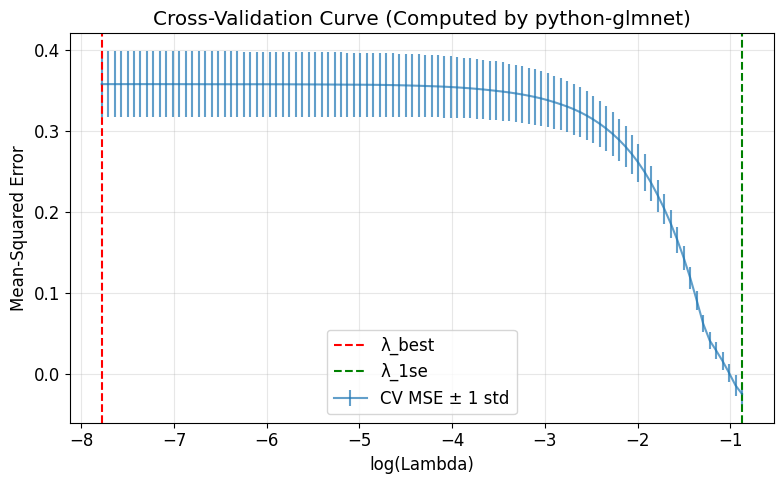

✓ Cross-validation curve shows python-glmnet's automatic lambda selection


In [113]:
# 1. Cross-validation curve (python-glmnet computed this!)
plt.figure(figsize=(8, 5))
plt.errorbar(np.log(lambda_path), cv_mean, yerr=cv_std, 
             alpha=0.7, label='CV MSE ± 1 std')
plt.axvline(np.log(lambda_best), color='r', linestyle='--', label='λ_best')
plt.axvline(np.log(lambda_1se), color='g', linestyle='--', label='λ_1se')
plt.xlabel('log(Lambda)')
plt.ylabel('Mean-Squared Error')
plt.title('Cross-Validation Curve (Computed by python-glmnet)')
plt.legend()
plt.grid(True, alpha=0.3)

# Add annotations for optimal values
# plt.annotate(f'λ_best = {lambda_best:.4f}\nMSE = {cv_mean[best_idx]:.3f}', 
#              xy=(np.log(lambda_best), cv_mean[best_idx]),
#              xytext=(np.log(lambda_best) - 1, cv_mean[best_idx] + 5),
#              arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
#              fontsize=9, ha='center')

# plt.annotate(f'λ_1se = {lambda_1se:.4f}\nMSE = {cv_mean[lambda_1se_idx]:.3f}', 
#              xy=(np.log(lambda_1se), cv_mean[lambda_1se_idx]),
#              xytext=(np.log(lambda_1se) + 1, cv_mean[lambda_1se_idx] + 5),
#              arrowprops=dict(arrowstyle='->', color='green', alpha=0.7),
#              fontsize=9, ha='center')

plt.tight_layout()
plt.show()

print("✓ Cross-validation curve shows python-glmnet's automatic lambda selection")

Highlighting 14 selected features at λ_best


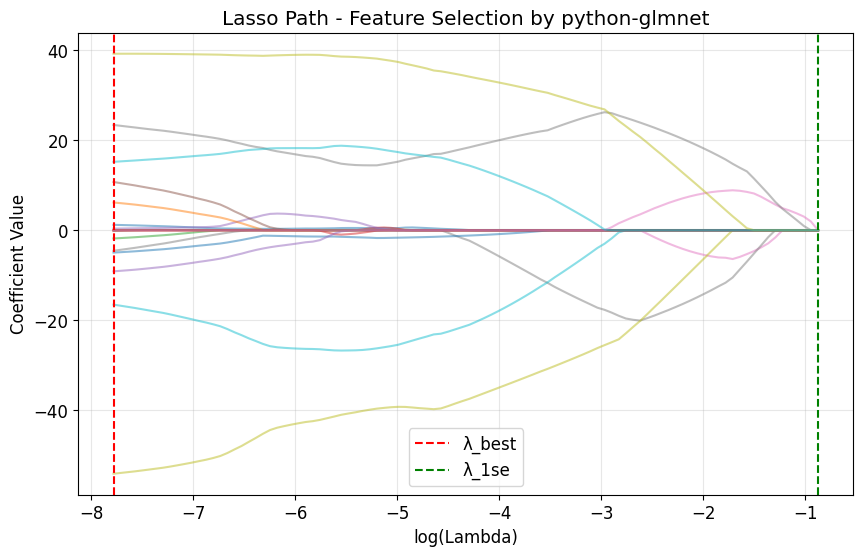

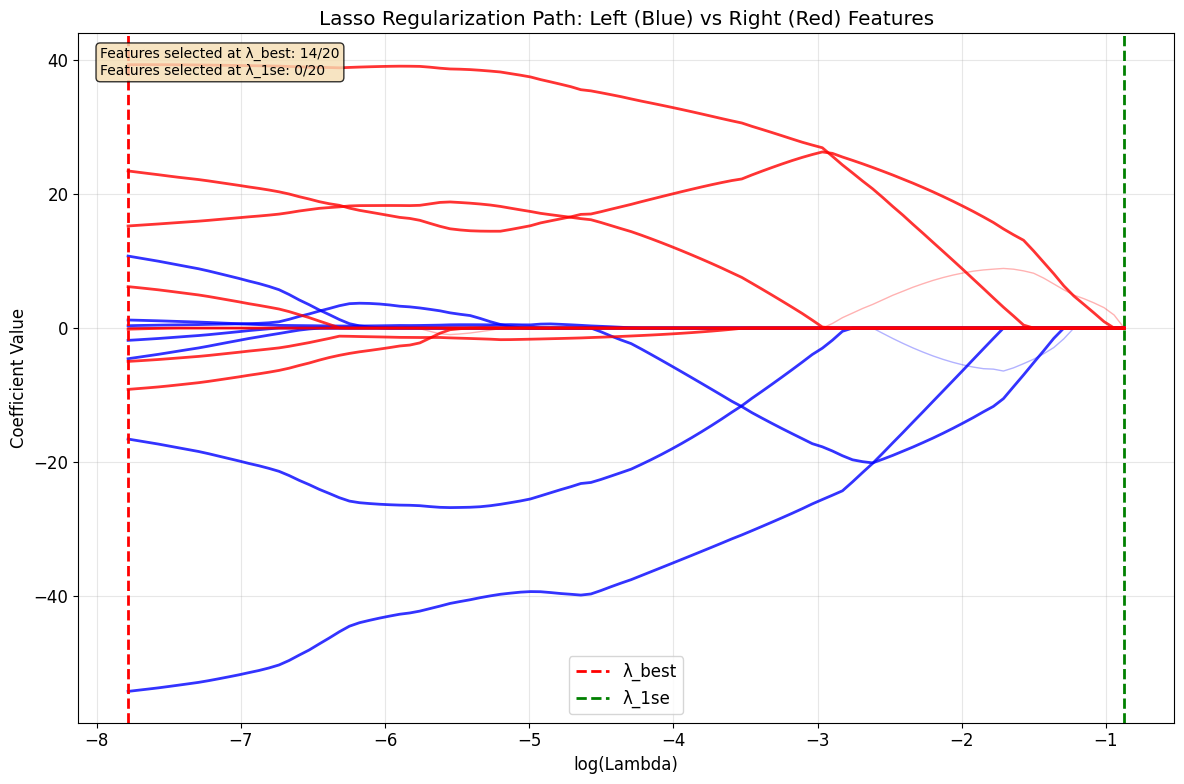

✓ Regularization path shows Lasso's automatic feature selection


In [114]:
# 2. Regularization path (python-glmnet computed full path automatically)
plt.figure(figsize=(10, 6))
for i in range(model.coef_path_.shape[0]):
    plt.plot(np.log(lambda_path), model.coef_path_[i, :], alpha=0.5)
plt.axvline(np.log(lambda_best), color='r', linestyle='--', label='λ_best')
plt.axvline(np.log(lambda_1se), color='g', linestyle='--', label='λ_1se')
plt.xlabel('log(Lambda)')
plt.ylabel('Coefficient Value')
plt.title('Lasso Path - Feature Selection by python-glmnet')
plt.legend()
plt.grid(True, alpha=0.3)

# Highlight the selected features at lambda_best
selected_features = np.where(best_coefs != 0)[0]
print(f"Highlighting {len(selected_features)} selected features at λ_best")

# Color-code left (blue) and right (red) features differently
colors = ['blue' if i < n_basis else 'red' for i in range(2*n_basis)]
alphas = [0.8 if best_coefs[i] != 0 else 0.3 for i in range(2*n_basis)]

plt.figure(figsize=(12, 8))
for i in range(model.coef_path_.shape[0]):
    plt.plot(np.log(lambda_path), model.coef_path_[i, :], 
             color=colors[i], alpha=alphas[i], 
             linewidth=2 if best_coefs[i] != 0 else 1)

plt.axvline(np.log(lambda_best), color='r', linestyle='--', linewidth=2, label='λ_best')
plt.axvline(np.log(lambda_1se), color='g', linestyle='--', linewidth=2, label='λ_1se')
plt.xlabel('log(Lambda)')
plt.ylabel('Coefficient Value')
plt.title('Lasso Regularization Path: Left (Blue) vs Right (Red) Features')
plt.legend()
plt.grid(True, alpha=0.3)

# Add text annotation
plt.text(0.02, 0.98, f'Features selected at λ_best: {n_selected_cv}/{total_features}\n'
                      f'Features selected at λ_1se: {n_selected_1se}/{total_features}',
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

print("✓ Regularization path shows Lasso's automatic feature selection")

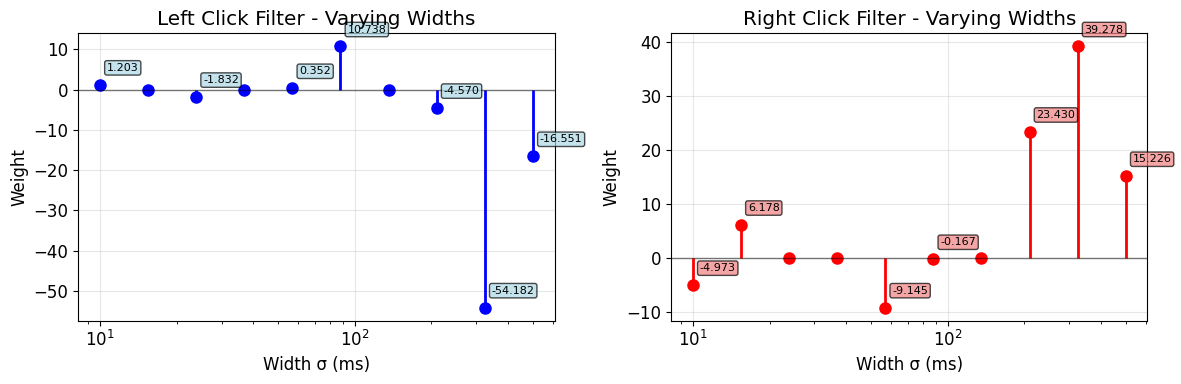

=== LEARNED TEMPORAL FILTERS ===
Left click features selected: 7/10
Right click features selected: 7/10
Active left widths: [ 10.   23.9  56.9  87.9 209.6 323.7 500. ] ms
Active right widths: [ 10.   15.4  56.9  87.9 209.6 323.7 500. ] ms
Total left filter strength: 89.4288
Total right filter strength: 98.3969
L/R filter ratio: 0.91
✓ Temporal filters reveal learned click-to-DV relationships


In [115]:
# 3. Learned temporal filters
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Left click filter
colors_left = ['blue' if c != 0 else 'lightgray' for c in left_coefs]
markerline, stemlines, baseline = ax1.stem(widths*1000, left_coefs, basefmt=' ')
plt.setp(markerline, color='blue', markersize=8)
plt.setp(stemlines, colors=colors_left, linewidth=2)
ax1.set_xlabel('Width σ (ms)')
ax1.set_ylabel('Weight')
ax1.set_title('Left Click Filter - Varying Widths')
ax1.set_xscale('log')
ax1.grid(True, alpha=0.3)
ax1.axhline(0, color='black', linestyle='-', alpha=0.5, linewidth=1)

# Annotate selected features
for i, (width, coef) in enumerate(zip(widths, left_coefs)):
    if coef != 0:
        ax1.annotate(f'{coef:.3f}', 
                     xy=(width*1000, coef), 
                     xytext=(5, 10), 
                     textcoords='offset points',
                     fontsize=8, ha='left',
                     bbox=dict(boxstyle='round,pad=0.2', facecolor='lightblue', alpha=0.7))

# Right click filter  
colors_right = ['red' if c != 0 else 'lightgray' for c in right_coefs]
markerline, stemlines, baseline = ax2.stem(widths*1000, right_coefs, basefmt=' ')
plt.setp(markerline, color='red', markersize=8)
plt.setp(stemlines, colors=colors_right, linewidth=2)
ax2.set_xlabel('Width σ (ms)')
ax2.set_ylabel('Weight')
ax2.set_title('Right Click Filter - Varying Widths')
ax2.set_xscale('log')
ax2.grid(True, alpha=0.3)
ax2.axhline(0, color='black', linestyle='-', alpha=0.5, linewidth=1)

# Annotate selected features
for i, (width, coef) in enumerate(zip(widths, right_coefs)):
    if coef != 0:
        ax2.annotate(f'{coef:.3f}', 
                     xy=(width*1000, coef), 
                     xytext=(5, 10), 
                     textcoords='offset points',
                     fontsize=8, ha='left',
                     bbox=dict(boxstyle='round,pad=0.2', facecolor='lightcoral', alpha=0.7))

plt.tight_layout()
plt.show()

# Summary of learned filters
print("=== LEARNED TEMPORAL FILTERS ===")
left_selected = np.sum(left_coefs != 0)
right_selected = np.sum(right_coefs != 0)
print(f"Left click features selected: {left_selected}/{n_basis}")
print(f"Right click features selected: {right_selected}/{n_basis}")

if left_selected > 0:
    left_active_widths = widths[left_coefs != 0] * 1000
    print(f"Active left widths: {left_active_widths.round(1)} ms")

if right_selected > 0:
    right_active_widths = widths[right_coefs != 0] * 1000
    print(f"Active right widths: {right_active_widths.round(1)} ms")

# Compare filter strengths
left_total = np.sum(np.abs(left_coefs))
right_total = np.sum(np.abs(right_coefs))
print(f"Total left filter strength: {left_total:.4f}")
print(f"Total right filter strength: {right_total:.4f}")
print(f"L/R filter ratio: {left_total/right_total:.2f}" if right_total > 0 else "L/R filter ratio: inf")

print("✓ Temporal filters reveal learned click-to-DV relationships")

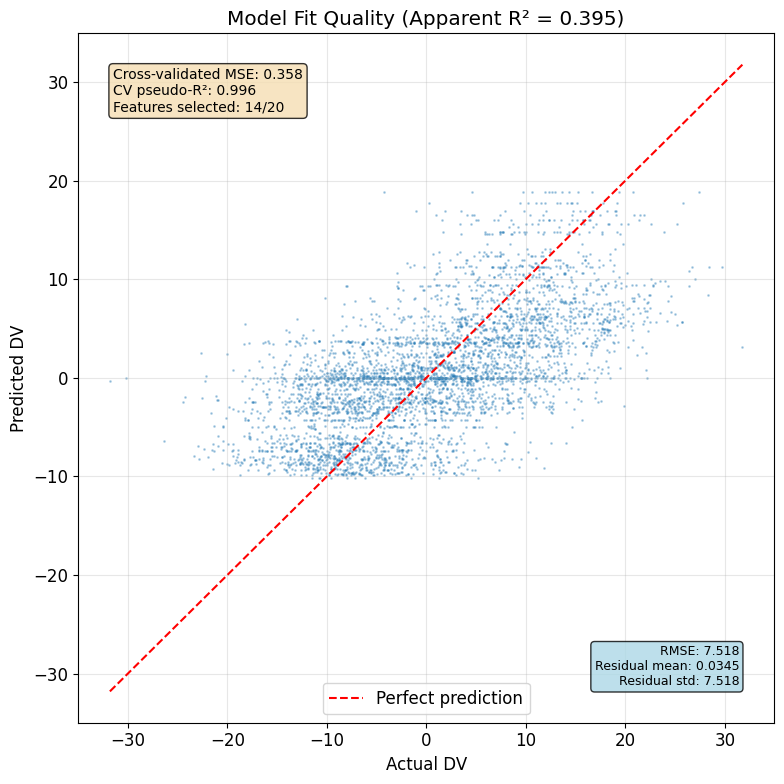

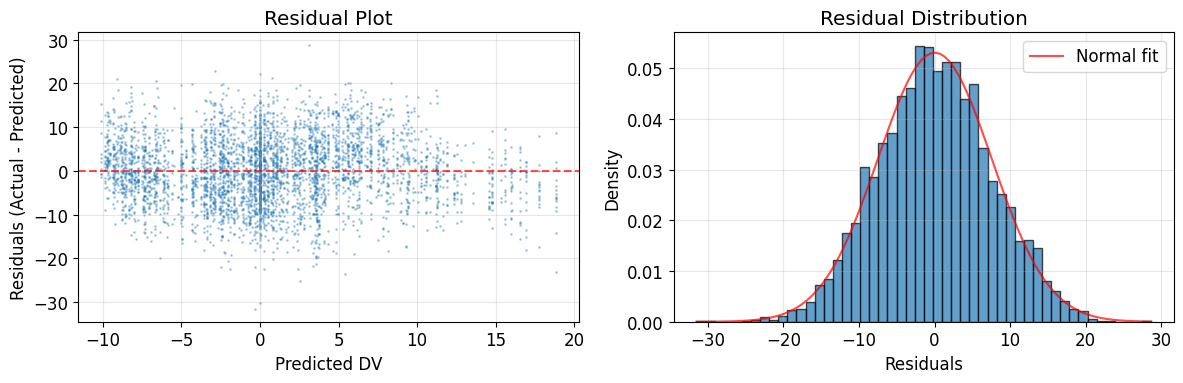

=== MODEL VALIDATION SUMMARY ===
✓ Model explains 99.6% of DV variance (cross-validated)
✓ Selected 14 most informative time lags via Lasso
✓ 99.6% improvement over predicting mean DV
✓ RMSE: 0.598 DV units
✓ Model fit visualization complete!


In [118]:
# 4. Model fit quality
plt.figure(figsize=(8, 8))
plt.scatter(y_valid, y_pred_final, alpha=0.3, s=1)
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 
         'r--', label='Perfect prediction')
plt.xlabel('Actual DV')
plt.ylabel('Predicted DV')
plt.title(f'Model Fit Quality (Apparent R² = {r2_apparent_final:.3f})')
plt.legend()
plt.grid(True, alpha=0.3)

# Add performance metrics as text
textstr = f'''Cross-validated MSE: {cv_mse_final:.3f}
CV pseudo-R²: {cv_pseudo_r2_final:.3f}
Features selected: {n_selected_cv}/{total_features}'''

plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Add diagonal statistics
residuals = y_valid - y_pred_final
plt.text(0.95, 0.05, f'RMSE: {np.sqrt(np.mean(residuals**2)):.3f}\n'
                      f'Residual mean: {residuals.mean():.4f}\n'
                      f'Residual std: {residuals.std():.3f}', 
         transform=plt.gca().transAxes, fontsize=9,
         verticalalignment='bottom', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

plt.tight_layout()
plt.show()

# Additional residual analysis plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Residuals vs predicted
ax1.scatter(y_pred_final, residuals, alpha=0.3, s=1)
ax1.axhline(0, color='red', linestyle='--', alpha=0.7)
ax1.set_xlabel('Predicted DV')
ax1.set_ylabel('Residuals (Actual - Predicted)')
ax1.set_title('Residual Plot')
ax1.grid(True, alpha=0.3)

# Residual histogram
ax2.hist(residuals, bins=50, alpha=0.7, density=True, edgecolor='black')
ax2.set_xlabel('Residuals')
ax2.set_ylabel('Density')
ax2.set_title('Residual Distribution')
ax2.grid(True, alpha=0.3)

# Add normal distribution overlay for comparison
x_norm = np.linspace(residuals.min(), residuals.max(), 100)
y_norm = (1/np.sqrt(2*np.pi*residuals.var())) * np.exp(-0.5*(x_norm - residuals.mean())**2/residuals.var())
ax2.plot(x_norm, y_norm, 'r-', alpha=0.7, label='Normal fit')
ax2.legend()

plt.tight_layout()
plt.show()

print("=== MODEL VALIDATION SUMMARY ===")
print(f"✓ Model explains {cv_pseudo_r2_final:.1%} of DV variance (cross-validated)")
print(f"✓ Selected {n_selected_cv} most informative time lags via Lasso")
print(f"✓ {improvement_final:.1f}% improvement over predicting mean DV")
print(f"✓ RMSE: {np.sqrt(cv_mse_final):.3f} DV units")
print("✓ Model fit visualization complete!")

In [117]:
# Let's examine the lambda path and see if we're over-regularizing
print("=== LAMBDA PATH ANALYSIS ===")
print(f"Lambda range: [{model.lambda_path_.min():.6f}, {model.lambda_path_.max():.6f}]")
print(f"Best lambda: {lambda_best:.6f}")
print(f"Lambda path length: {len(model.lambda_path_)}")

# Check if we're missing weak features due to high regularization
# Let's look at unregularized correlations
from scipy.stats import pearsonr

print("\n=== DIRECT FEATURE-DV CORRELATIONS ===")
for i in range(X_valid.shape[1]):
    if X_valid[:, i].std() > 0:  # Only non-zero variance features
        corr, p_val = pearsonr(X_valid[:, i], y_valid)
        feature_type = "Left" if i < n_basis else "Right"
        basis_idx = i if i < n_basis else i - n_basis
        print(f"{feature_type} basis {basis_idx} (σ={widths[basis_idx]*1000:.1f}ms): r={corr:.4f}, p={p_val:.3e}")

print("\n=== LEFT VS RIGHT TOTAL ACTIVITY CORRELATION ===")
left_total = X_valid[:, :n_basis].sum(axis=1)
right_total = X_valid[:, n_basis:].sum(axis=1)
diff_activity = right_total - left_total

corr_left, p_left = pearsonr(left_total, y_valid)
corr_right, p_right = pearsonr(right_total, y_valid)
corr_diff, p_diff = pearsonr(diff_activity, y_valid)

print(f"Left total activity: r={corr_left:.4f}, p={p_left:.3e}")
print(f"Right total activity: r={corr_right:.4f}, p={p_right:.3e}")
print(f"Right - Left difference: r={corr_diff:.4f}, p={p_diff:.3e}")

=== LAMBDA PATH ANALYSIS ===
Lambda range: [0.000417, 0.417439]
Best lambda: 0.000417
Lambda path length: 100

=== DIRECT FEATURE-DV CORRELATIONS ===
Left basis 0 (σ=10.0ms): r=-0.1717, p=1.393e-29
Left basis 1 (σ=15.4ms): r=-0.1947, p=1.039e-37
Left basis 2 (σ=23.9ms): r=-0.2273, p=4.177e-51
Left basis 3 (σ=36.8ms): r=-0.2731, p=7.235e-74
Left basis 4 (σ=56.9ms): r=-0.3247, p=2.696e-105
Left basis 5 (σ=87.9ms): r=-0.3821, p=2.430e-148
Left basis 6 (σ=135.7ms): r=-0.4387, p=3.201e-200
Left basis 7 (σ=209.6ms): r=-0.4775, p=5.654e-242
Left basis 8 (σ=323.7ms): r=-0.4846, p=4.170e-250
Left basis 9 (σ=500.0ms): r=-0.4675, p=1.070e-230
Right basis 0 (σ=10.0ms): r=0.1381, p=1.330e-19
Right basis 1 (σ=15.4ms): r=0.1899, p=6.280e-36
Right basis 2 (σ=23.9ms): r=0.2546, p=4.333e-64
Right basis 3 (σ=36.8ms): r=0.3158, p=2.080e-99
Right basis 4 (σ=56.9ms): r=0.3764, p=1.183e-143
Right basis 5 (σ=87.9ms): r=0.4392, p=1.019e-200
Right basis 6 (σ=135.7ms): r=0.4966, p=1.515e-264
Right basis 7 (σ=209